In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from fna.tools.signals import make_simple_kernel, pad_array

import os
import sys
import re
import sys

** mayavi.mlab ** package is not installed. To have functions using mayavi.mlab please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.


In [2]:
sys.path.append("demyelination/") # we need this to successfully read pickle files

In [9]:
! ls demyelination/data/plasticity-aone/activity/

'spk_plasticity-aone_T=0_eCa=0.01_iCa=0.01_0'
'spk_plasticity-aone_T=0_eCa=0.01_iCa=0.01_1'
'spk_plasticity-aone_T=0_eCa=0.01_iCa=0.01_2'
'spk_plasticity-aone_T=0_eCa=0.01_iCa=0.01_3'
'spk_plasticity-aone_T=0_eCa=0.01_iCa=0.01_4'
'spk_plasticity-aone_T=0_eCa=0.01_iCa=0.01_5'
'spk_plasticity-aone_T=0_eCa=0.01_iCa=0.01_6'
'spk_plasticity-aone_T=0_eCa=0.01_iCa=0.01_7'
'spk_plasticity-aone_T=0_eCa=0.02_iCa=0.02_0'
'spk_plasticity-aone_T=0_eCa=0.02_iCa=0.02_1'
'spk_plasticity-aone_T=0_eCa=0.02_iCa=0.02_2'
'spk_plasticity-aone_T=0_eCa=0.02_iCa=0.02_3'
'spk_plasticity-aone_T=0_eCa=0.02_iCa=0.02_4'
'spk_plasticity-aone_T=0_eCa=0.02_iCa=0.02_5'
'spk_plasticity-aone_T=0_eCa=0.02_iCa=0.02_6'
'spk_plasticity-aone_T=0_eCa=0.02_iCa=0.02_7'
'spk_plasticity-aone_T=0_eCa=0.05_iCa=0.05_0'
'spk_plasticity-aone_T=0_eCa=0.05_iCa=0.05_1'
'spk_plasticity-aone_T=0_eCa=0.05_iCa=0.05_2'
'spk_plasticity-aone_T=0_eCa=0.05_iCa=0.05_3'
'spk_plasticity-aone_T=0_eCa=0.05_iCa=0.05_4'
'spk_plasticity-aone_T=0_eCa=0.05_

In [3]:
def percentageconn (conn):
    ne = 2000 / 8
    ni = 500 / 8
    
    # populationType_connetionType
    ex_ex = [c / ne for c in conn['ex']['eA1']]
    ex_in = [c / ne for c in conn['in']['eA1']]

    in_ex = [c / ni for c in conn['ex']['eA1']]
    in_in = [c / ni for c in conn['in']['eA1']]
    
    return (ex_ex, ex_in, in_ex, in_in)

In [427]:
def percentageconn (conn):
    r = len(conn['ex']['eA1'])
    
    # populationType_connetionType
    ex_ex = [conn['ex']['eA1'][i] / \
        (conn['ex']['eA1'][i] + conn['in']['eA1'][i]) for i in range(r)]
    ex_in = [conn['in']['eA1'][i] / \
        (conn['ex']['eA1'][i] + conn['in']['eA1'][i]) for i in range(r)]
    
    in_ex = [conn['ex']['iA1'][i] / \
        (conn['ex']['iA1'][i] + conn['in']['iA1'][i]) for i in range(r)]
    in_in = [conn['in']['iA1'][i] / \
        (conn['ex']['iA1'][i] + conn['in']['iA1'][i]) for i in range(r)]
    
    return (ex_ex, ex_in, in_ex, in_in)

In [4]:
def gatherSpikes(path, filename, nthreads, brainPart, neuronIdFirst, neuronIdLast):
    '''
    Example Usage: 
    gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
                 "spk_adaptation-aone-plast_T=0_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
                 2, "iA1", 2001, 2500)
    '''
    
    spikes = {}
    files = {}
    
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))
    
    for neuron in range(neuronIdFirst, neuronIdLast+1):
        rthread = neuron % nthreads
        files[0].spikeobj[brainPart].spiketrains[neuron] = files[rthread].spikeobj[brainPart].spiketrains[neuron]
    
    return files[0].spikeobj[brainPart]

def gatherConnectivity(path, filename, nthreads, brainPart, DenType):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    conn = np.sum([files[x].connectivity['z_connected']['Den'][DenType][brainPart] for x in range(nthreads)], axis=0)
    
    return conn


def gatherZ(path, filename, nthreads, brainPart, DenType):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    z = np.sum([files[x].connectivity['z']['Den'][DenType][brainPart] for x in range(nthreads)], axis=0)
    
    return z

def gatherNestConnectivity(path, filename, nthreads, source, target):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    conn = np.sum([files[x].nestconnectivity[source][target] for x in range(nthreads)], axis=0)
    
    return conn

In [20]:
fls = [
    #"spk_adaptation-aone-plast_T=1_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_0",
    "spk_adaptation-aone-plast_T=4_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_0",
    "spk_adaptation-aone-plast_T=0_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_1",
    "spk_adaptation-aone-plast_T=5_nuX_aone=16.0_gamma_aone=9.0_w_input_aone=15.0_1",
    "spk_adaptation-aone-plast_T=9_nuX_aone=16.0_gamma_aone=9.0_w_input_aone=15.0_1",
    "spk_adaptation-aone-plast_T=9_nuX_aone=16.0_gamma_aone=9.0_w_input_aone=15.0_1"
]

fl = fls[3][:-1]

pth = "demyelination/data/adaptation-aone-plast/activity/"

l = 50000+1
recordstep = 10000
s = recordstep

spk = pd.read_pickle(pth + fls[2])

def smoothedspikes(spikes):
    tau = 10
    #spikes = spikes.time_slice(0, l)

    kernel = make_simple_kernel('exp', tau=tau, width=100., height=1./tau, resolution=1.)
    axis_, rates = spikes.averaged_instantaneous_rate(resolution=1., kernel=kernel, norm=1000)
    
    return axis_, rates

In [21]:
eA1spikes = gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
             fl, \
             8, "eA1", 1, 2000)

iA1spikes = gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
             fl, \
             8, "iA1", 2001, 2500)

In [22]:
ex_eA1 = gatherConnectivity("demyelination/data/adaptation-aone-plast/activity/", \
             fl, \
             8, "eA1", "ex")

in_eA1 = gatherConnectivity("demyelination/data/adaptation-aone-plast/activity/", \
             fl, \
             8, "eA1", "in")

ex_iA1 = gatherConnectivity("demyelination/data/adaptation-aone-plast/activity/", \
             fl, \
             8, "iA1", "ex")

in_iA1 = gatherConnectivity("demyelination/data/adaptation-aone-plast/activity/", \
             fl, \
             8, "iA1", "in")

# DendriteType_Population
#perc_ex_eA1 = np.divide(ex_eA1, np.sum((ex_eA1, in_eA1), axis=0))
perc_ex_eA1 = np.divide(ex_eA1, 2000*2000)
perc_in_eA1 = np.divide(in_eA1, 500*2000)

perc_ex_iA1 = np.divide(ex_iA1, 500*2000)
perc_in_iA1 = np.divide(in_iA1, 500*500)

In [23]:
ex_eA1 = gatherNestConnectivity("demyelination/data/adaptation-aone-plast/activity/", \
             fl, \
             8, "eA1", "eA1")

in_eA1 = gatherNestConnectivity("demyelination/data/adaptation-aone-plast/activity/", \
             fl, \
             8, "iA1", "eA1")

ex_iA1 = gatherNestConnectivity("demyelination/data/adaptation-aone-plast/activity/", \
             fl, \
             8, "eA1", "iA1")

in_iA1 = gatherNestConnectivity("demyelination/data/adaptation-aone-plast/activity/", \
             fl, \
             8, "iA1", "iA1")

# DendriteType_Population
#perc_ex_eA1 = np.divide(ex_eA1, np.sum((ex_eA1, in_eA1), axis=0))
perc_ex_eA1 = np.divide(ex_eA1, 2000*2000)
perc_in_eA1 = np.divide(in_eA1, 500*2000)

perc_ex_iA1 = np.divide(ex_iA1, 500*2000)
perc_in_iA1 = np.divide(in_iA1, 500*500)

In [24]:
perc_ex_eA1, perc_in_eA1, perc_ex_iA1, perc_in_iA1

(array([0.09986475, 0.1018895 , 0.105266  , 0.1080565 , 0.11067575,
        0.1132265 ]),
 array([0.100218, 0.100218, 0.100218, 0.100218, 0.100218, 0.100218]),
 array([0.100029, 0.100029, 0.100029, 0.100029, 0.100029, 0.100029]),
 array([0.101008, 0.101008, 0.101008, 0.101008, 0.101008, 0.101008]))

In [25]:
z_ex_eA1 = gatherZ("demyelination/data/adaptation-aone-plast/activity/", \
             "spk_adaptation-aone-plast_T=3_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
             8, "eA1", "ex")

z_in_eA1 = gatherZ("demyelination/data/adaptation-aone-plast/activity/", \
             "spk_adaptation-aone-plast_T=3_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
             8, "eA1", "in")

z_ex_iA1 = gatherZ("demyelination/data/adaptation-aone-plast/activity/", \
             "spk_adaptation-aone-plast_T=3_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
             8, "iA1", "ex")

z_in_iA1 = gatherZ("demyelination/data/adaptation-aone-plast/activity/", \
             "spk_adaptation-aone-plast_T=3_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
             8, "iA1", "in")


In [516]:
z_ex_eA1, z_in_eA1, z_ex_iA1, in_iA1

(array([1257.40572818, 2079.68892618, 2577.2030778 , 3060.29452309,
        3550.40646919, 4067.26942816, 4600.07646513, 5125.38628674,
        5675.76619354, 6222.9348947 ]),
 array([1257.40572818, 1655.28892618, 1658.2030778 , 1707.68815034,
        1812.60242096, 1929.50215737, 2065.60873094, 2209.27036438,
        2354.80762773, 2508.7321946 ]),
 array([ 272.24287673,  467.45178432,  608.43265375,  753.63887306,
         897.55225852, 1054.31668951, 1206.14816083, 1360.43481378,
        1516.3653405 , 1677.76534871]),
 array([  0,  54,  94, 126, 173, 215, 256, 305, 345, 406]))

In [532]:
ex_eA1, in_eA1, ex_iA1, in_iA1

(array([   0, 1102, 1725, 2285, 2789, 3325, 3885, 4440, 4964, 5524]),
 array([   0,  231,  421,  580,  747,  907, 1058, 1213, 1375, 1523]),
 array([   0,  217,  396,  554,  726,  867, 1017, 1167, 1338, 1496]),
 array([  0,  54,  94, 126, 173, 215, 256, 305, 345, 406]))

In [27]:
for x in range(0, 100000, 10000):
    print(eA1spikes.time_slice(x, x+1000).mean_rate())

7.511
7.398
7.3055
7.5215
7.3655
0.0
0.0
0.0
0.0
0.0


In [26]:
for x in range(0, 100000, 10000):
    print(iA1spikes.time_slice(x, x+1000).mean_rate())

13.704
13.166
13.202
13.132
13.262
0.0
0.0
0.0
0.0
0.0


ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

<Figure size 432x288 with 0 Axes>

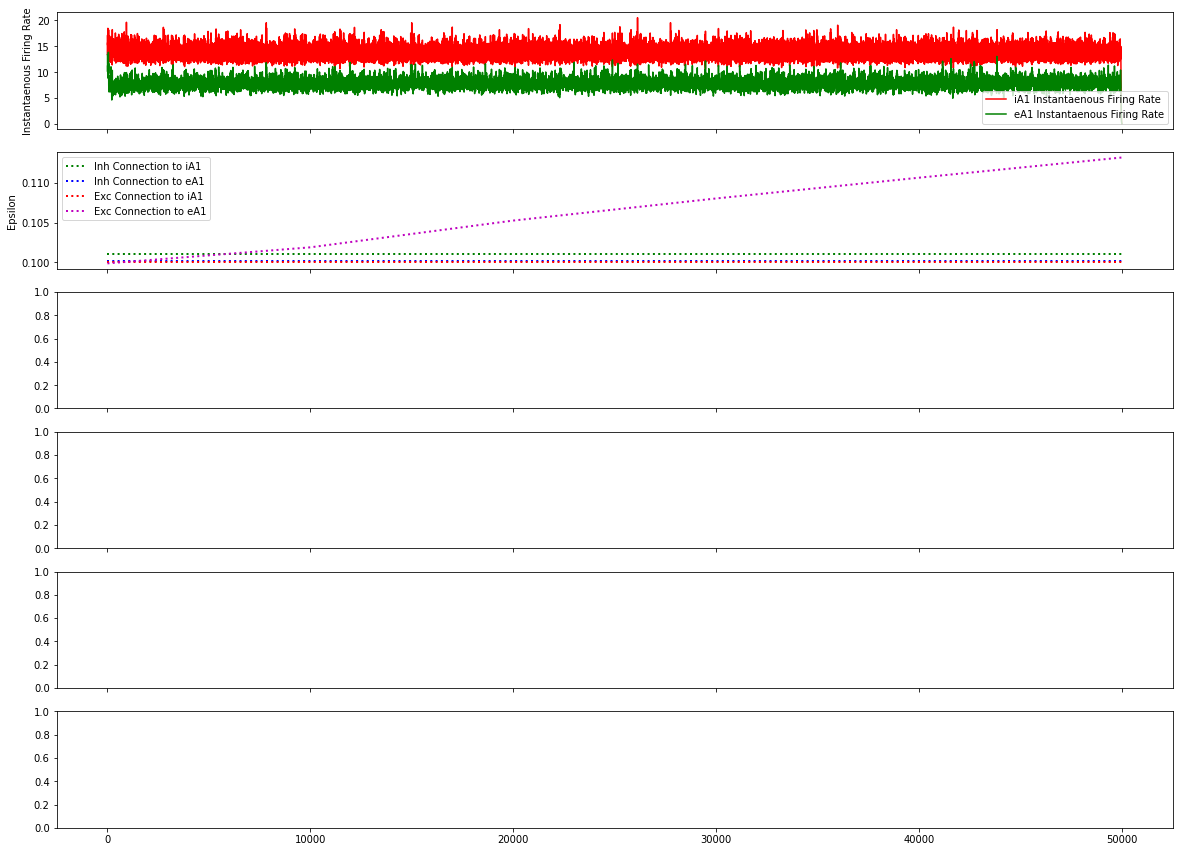

In [28]:
plt.clf()
fig, ax = plt.subplots(6, 1, sharex=True)
fig.set_size_inches(20, 15)

#spk.spikeobj['eA1'] = spk.spikeobj['eA1'].time_slice(60000, 65000)
#spk.spikeobj['iA1'] = spk.spikeobj['iA1'].time_slice(60000, 65000)

#plt.title(fls[0])

# Inst Firing Rate
axis = ax[0]
#'''
x, y = smoothedspikes(iA1spikes)
axis.plot(x, y, label="iA1 Instantaenous Firing Rate", c='r')

x, y = smoothedspikes(eA1spikes)
# .time_slice(1000, 3000)
axis.plot(x, y, label="eA1 Instantaenous Firing Rate", c='g')
#'''
axis.set_ylabel("Instantaenous Firing Rate")
axis.legend()
#axis.set_xlim((0, 5000))

# Connectivity
axis = ax[1]

#ex_ex, ex_in, in_ex, in_in = percentageconn(spk.connectivity['z_connected']['Den'])
'''percentage conn
axis.plot(range(s, l, recordstep), perc_in_iA1, label="Inh Connection to iA1", linewidth=2, ls=':', c='g')
axis.plot(range(s, l, recordstep), perc_in_eA1, label="Inh Connection to eA1", linewidth=2, ls=':', c='b')
axis.plot(range(s, l, recordstep), perc_ex_iA1, label="Exc Connection to iA1", linewidth=2, ls=':', c='r')
axis.plot(range(s, l, recordstep), perc_ex_eA1, label="Exc Connection to eA1", linewidth=2, ls=':', c='m')
'''

#'''percentage conn
axis.plot(range(0, l, recordstep), perc_in_iA1, label="Inh Connection to iA1", linewidth=2, ls=':', c='g')
axis.plot(range(0, l, recordstep), perc_in_eA1, label="Inh Connection to eA1", linewidth=2, ls=':', c='b')
axis.plot(range(0, l, recordstep), perc_ex_iA1, label="Exc Connection to iA1", linewidth=2, ls=':', c='r')
axis.plot(range(0, l, recordstep), perc_ex_eA1, label="Exc Connection to eA1", linewidth=2, ls=':', c='m')
#'''

'''# raw conn numbers
axis.plot(range(s, l, recordstep), in_iA1, label="Inh Connection to iA1", linewidth=2, ls=':', c='g')
axis.plot(range(s, l, recordstep), in_eA1, label="Inh Connection to eA1", linewidth=2, ls=':', c='b')
axis.plot(range(s, l, recordstep), ex_iA1, label="Exc Connection to iA1", linewidth=2, ls=':', c='r')
axis.plot(range(s, l, recordstep), ex_eA1, label="Exc Connection to eA1", linewidth=2, ls=':', c='m')
'''
axis.set_ylabel("Epsilon")
axis.legend()

# Calcium
axis = ax[2]

axis.plot(range(s, l, recordstep), spk.calcium['iA1'], label="iA1 Calcium Levels")
axis.plot(range(s, l, recordstep), spk.calcium['eA1'], label="eA1 Calcium Levels")

axis.set_ylabel("Calcium")
axis.legend()
'''
# Z
axis = ax[3]

#axis.plot(range(s, l, recordstep), spk.connectivity['z']['Axon']['in']['iA1'], label="Inhibitory Axons iA1")
#axis.plot(range(s, l, recordstep), spk.connectivity['z']['Axon']['in']['eA1'], label="iA1 Connectivity")
#axis.plot(range(s, l, recordstep), spk.connectivity['z']['Axon']['ex']['iA1'], label="iA1 Connectivity")
#axis.plot(range(s, l, recordstep), spk.connectivity['z']['Axon']['ex']['eA1'], label="Excitatory Axons eA1")
axis.plot(range(s, l, recordstep), z_ex_iA1, label="Exc Connection to iA1", linewidth=2, ls=':', c='r')
axis.plot(range(s, l, recordstep), z_in_iA1, label="Inh Connection to iA1", linewidth=2, ls=':', c='g')
axis.plot(range(s, l, recordstep), z_in_eA1, label="Inh Connection to eA1", linewidth=2, ls=':', c='b')
axis.plot(range(s, l, recordstep), z_ex_eA1, label="Exc Connection to eA1", linewidth=2, ls=':', c='m')

axis.set_ylabel("Z")
axis.legend()

axis = ax[4]
part = "eA1"
eA1spikes.raster_plot(ax=axis, dt=10, display=False, color="green", ms=.1)
axis.set_ylabel(part)

axis = ax[5]
part = "iA1"
iA1spikes.raster_plot(ax=axis, dt=10, display=False, color="red", ms=.1)
axis.set_ylabel(part)
'''
axis.set_xlabel("Time (ms)")
axis.legend()

#plt.savefig("/home/pbr-student/Downloads/thesis-plots/plasticity.pdf")

In [30]:
spk.calcium['eA1']

[0.046155309101822584,
 0.06322763428018341,
 0.06988900484082965,
 0.07207634328932244,
 0.07313958473190176,
 0.07327052242212949,
 0.07303793037398734,
 0.07283755898892491,
 0.07272948924471408,
 0.07266314248120709]

### Notes

T=1 A simple run without plasticity enabled found that the calcium levels reach the activity level / 100 in 40s.
<br />
T=2 The connections are growing, and the activity levels are maintained. However, it makes sense to try a lower rate.
<br />
T=3 The connections are constantly growing, and it is not clear why they don't stop despite the calcium levels having stagnated. The ratio of the types of connectivity is 50-50, however, the results show 80-20 (exc-inh). (100s every 10s)
<br />
T=5 The connections grow, but the activity rate declines slightly.
<br />
T=6 A higher growth rate was tried. Now the activity rate declines faster. Makes sense to try a higher growth rate for the excitatory connections than the inhibitory ones.
<br />
T=7 There is nearly no growth in connections except for eA1 -> eA1. I have increased eta for exc connections to 10.0 to delay that process and allow the inh connections to grow, in the next experiment.
<br />
T=8